In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from termcolor import colored

## Reading the data: International tourist arrivals in India (2009-2019)

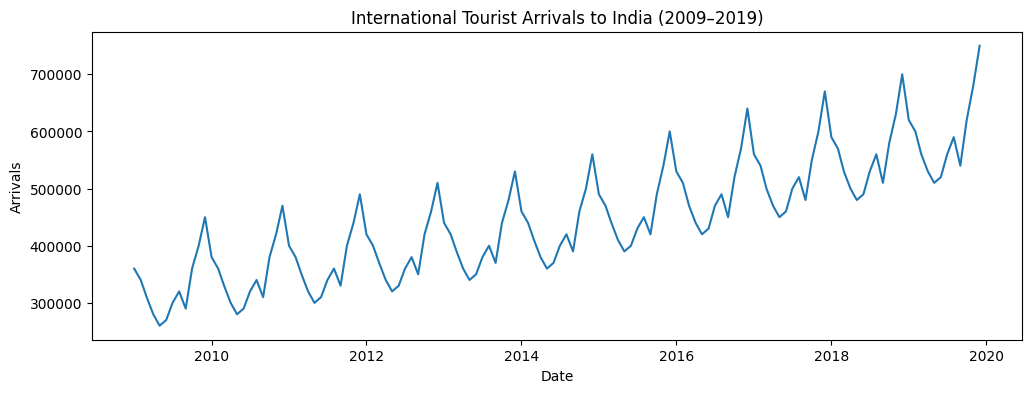

In [2]:
TA = pd.read_csv("tour.csv", index_col = "date", parse_dates = True)
# File 'tour.csv' has month-wise tourists arrival number (synthetic data) for 10 years
# 'TA' is the dataframe with the tourists data and new columns necessary for the time series method will be added.

# Plot
plt.figure(figsize=(12,4))
plt.plot(TA["arrivals"])
plt.title("International Tourist Arrivals to India (2009–2019)")
plt.xlabel("Date")
plt.ylabel("Arrivals")
#plt.grid(True)
plt.show()

In [3]:
# Dataframe
TA.index.freq = 'MS'  # series sampled at the start of each month
TA.head()

,arrivals
date,
2009-01-01,360000
2009-02-01,340000
2009-03-01,310000
2009-04-01,280000
2009-05-01,260000


## Stationarity Check using ADF test

In [4]:
def adf(series):   # Function does the ADF test
  check = adfuller(series.dropna(), autolag = 'AIC')
  print('ADF Statistics: %f' % check[0])
  print('p-value: %f' % check[1])

  if check[1] < 0.05:
    print(colored("The time series is stationary", "magenta"))
  else:
    print(colored("The time series is not stationary", "cyan"))  

adf(TA['arrivals'])

ADF Statistics: 2.793322
p-value: 1.000000
The time series is not stationary


In [5]:
adf(TA['arrivals'].diff().dropna())
print('--------------------------------')
adf(TA['arrivals'].diff().diff().dropna())

ADF Statistics: -1.170352
p-value: 0.686218
The time series is not stationary
--------------------------------
ADF Statistics: -108.187366
p-value: 0.000000
The time series is stationary


## ACF and PACF

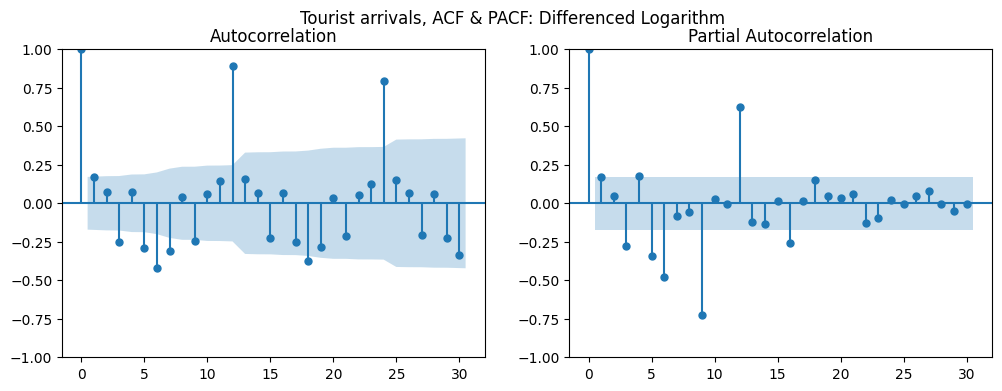

In [6]:
# Using logarithm and differencing to tourists arrival dataframe 'TA':
TA['log_arrivals'] = np.log(TA['arrivals'])
TA['log_diff'] = TA['log_arrivals'].diff()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(TA['log_diff'].dropna(), ax=axes[0], lags=30)
plot_pacf(TA['log_diff'].dropna(), ax=axes[1], lags=30)
plt.suptitle('Tourist arrivals, ACF & PACF: Differenced Logarithm')
plt.show()

In [7]:
# Dataframe
TA.head()

,arrivals,log_arrivals,log_diff
date,,,
2009-01-01,360000,12.793859,NaN
2009-02-01,340000,12.736701,-0.057158
2009-03-01,310000,12.644328,-0.092373
2009-04-01,280000,12.542545,-0.101783
2009-05-01,260000,12.468437,-0.074108


## Model

In [8]:
n_test = 12   # months
# Splitting the training and test set in the dataframe:
training = TA.iloc[:-n_test]
testing = TA.iloc[-n_test:] 

# Fitting ARIMA model on Tourist arrivals data (Log(data))
model = ARIMA(training['log_arrivals'], order=(12,1,1))
fit = model.fit()
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:           log_arrivals   No. Observations:                  120
Model:                ARIMA(12, 1, 1)   Log Likelihood                 376.965
Date:                Fri, 12 Sep 2025   AIC                           -725.930
Time:                        17:24:34   BIC                           -687.022
Sample:                    01-01-2009   HQIC                          -710.131
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0260      0.032     -0.809      0.419      -0.089       0.037
ar.L2          0.0136      0.022      0.609      0.543      -0.030       0.058
ar.L3         -0.0126      0.017     -0.733      0.4

/home/kamal12054/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Forecasting

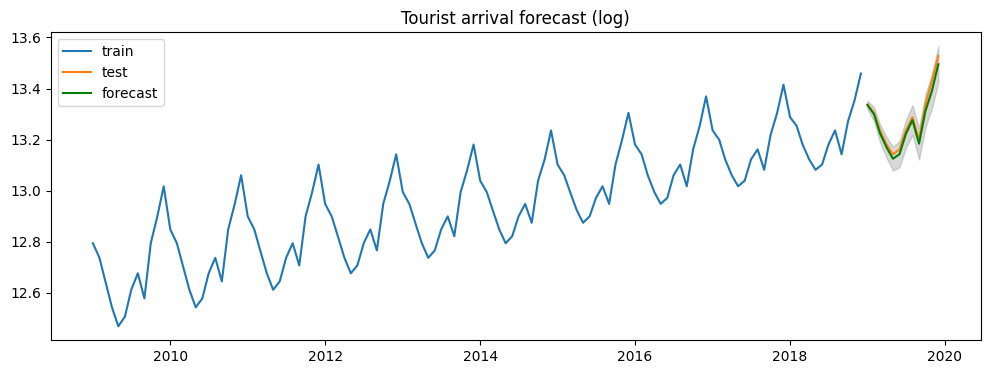

In [9]:
def forecast(fit, train, test, column, title):    
    prediction = fit.get_forecast(len(test))
    forecast = prediction.predicted_mean
    conf_int = prediction.conf_int()

    plt.figure(figsize=(12,4))
    plt.plot(train.index, train[column], label='train')
    plt.plot(forecast.index, test[column], label='test')
    plt.plot(forecast.index, forecast, label='forecast', color='green')
    plt.fill_between(forecast.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='grey', alpha=0.3)
    plt.title(title)
    plt.legend()
    plt.show()

forecast(fit, training, testing, 'log_arrivals', 'Tourist arrival forecast (log)')

## Model Evaluation

In [10]:
def error_rms(data):  # Mean squared error
  prediction = data.get_forecast(n_test)
  forecast = prediction.predicted_mean
  return np.sqrt(np.mean((testing['log_arrivals'] - forecast)**2))
    
def error_mae(data):  # Mean absolute error
  prediction = data.get_forecast(n_test)
  forecast = prediction.predicted_mean
  return np.mean(np.abs(testing['log_arrivals'] - forecast))

print('ARIMA(12,1,1) mean squared error (logged):', error_rms(fit))
print('ARIMA(12,1,1) mean absolute error (logged):', error_mae(fit))

ARIMA(12,1,1) mean squared error (logged): 0.019951535036559283
ARIMA(12,1,1) mean absolute error (logged): 0.01711119511441443
